In [1]:
%matplotlib widget
import torch
import os
import copy
import subprocess
import shlex

os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

from sphMath.sampling import buildDomainDescription
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.integration import getIntegrator
from sphMath.util import volumeToSupport
from sphMath.boundary import sampleDomainSDF
from sphMath.kernels import getKernelEnum
from sphMath.sdf import getSDF, sdfFunctions, operatorDict, sampleSDF
from sphMath.regions import buildRegion, filterRegion, plotRegions
from sphMath.modules.timestep import computeTimestep
from sphMath.schemes.weaklyCompressible import updateBodyParticles
from sphMath.schemes.deltaSPH import deltaPlusSPHScheme, DeltaPlusSPHSystem
from torch.profiler import profile,  ProfilerActivity
from sphMath.enums import *

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
dtype = torch.float32

nx = 8
L = 2
dim = 3
kernel = KernelType.Wendland2
targetNeighbors = n_h_to_nH(2.75,dim)
CFL = 0.3

integrationScheme = IntegrationSchemeType.symplecticEuler
dx = L / nx
band = 5

domain = buildDomainDescription(l = 2, dim = dim, periodic = True, device = device, dtype = dtype)
# domain.min = torch.tensor([-L/2, -2*L], device = device, dtype = dtype)
# domain.max = torch.tensor([L/2, 2*L], device = device, dtype = dtype)
# print(domain.min)
# domain.min = torch.tensor([-2*L/2,-L/2], device = device, dtype = dtype)
# domain.max = torch.tensor([5*L/2,L/2], device = device, dtype = dtype)
# interiorDomain = buildDomainDescription(l = L, dim = dim, periodic = False, device = device, dtype = dtype)
wrappedKernel = kernel
integrationScheme = getIntegrator(integrationScheme)

config = {
    'domain': domain,
    'kernel': wrappedKernel,
    'verletScale': 1.4,
    'shifting': {'scheme': 'delta', 'freeSurface': False},
    'surfaceDetection': {'active': False},
    'pressure':{'term': 'Antuono'},
    'fluid': {'rho0': 1, 'c_s': 20},    
    'gravity': {'active': False, 'magnitude': 9.81, 'mode': 'directional', 'direction': torch.tensor([0, -1], device = device, dtype = dtype)},
    'particle': {'nx': nx, 'dx': dx, 'targetNeighbors': targetNeighbors, 'band': band, 'support': volumeToSupport((L/nx)**dim, targetNeighbors, dim)},
}

In [3]:
from sphMath.schemes.states.wcsph import WeaklyCompressibleState

In [4]:
volume = (L/nx)**dim
support = volumeToSupport(volume, targetNeighbors, dim)


linspace = torch.linspace(-L/2 + dx/2, L/2 - dx/2, config['particle']['nx'], device=device, dtype=dtype)
_ = torch.meshgrid([linspace]*dim, indexing='ij')
positions = torch.stack(_, dim=-1).reshape(-1, dim)

# positions += torch.randn_like(positions) * dx * 0.1
# print(positions)

# positions = torch.rand((config['particle']['nx']**dim, dim), device=device, dtype=dtype) * L - L / 2
supports = torch.ones((config['particle']['nx']**dim), device=device, dtype=dtype) * support

In [5]:
particles = WeaklyCompressibleState(
    positions=positions,
    supports = supports,
    masses = torch.ones((config['particle']['nx']**dim), device=device, dtype=dtype) * volume * config['fluid']['rho0'],
    densities = torch.ones((config['particle']['nx']**dim), device=device, dtype=dtype) * config['fluid']['rho0'],
    velocities=torch.zeros((config['particle']['nx']**dim, dim), device=device, dtype=dtype),

    pressures = torch.zeros((config['particle']['nx']**dim), device=device, dtype=dtype),
    soundspeeds=torch.ones((config['particle']['nx']**dim), device=device, dtype=dtype) * config['fluid']['c_s'],

    kinds = torch.zeros((config['particle']['nx']**dim), device=device, dtype=dtype),
    materials = torch.zeros((config['particle']['nx']**dim), device=device, dtype=dtype),
    UIDs = torch.arange(0, config['particle']['nx']**dim, device=device, dtype=dtype),
    UIDcounter= config['particle']['nx']**dim,
)

In [6]:
from sphMath.neighborhood import filterNeighborhood, filterNeighborhoodByKind, coo_to_csr, evaluateNeighborhood, SupportScheme
from sphMath.modules.density import computeDensity

In [7]:
neighborhood, neighbors = evaluateNeighborhood(particles, domain, wrappedKernel, verletScale = 1.0, mode = SupportScheme.SuperSymmetric, priorNeighborhood=None, computeHessian=False, computeDkDh=False, only_j = False)
particles.numNeighbors = coo_to_csr(filterNeighborhoodByKind(particles, neighbors.neighbors, which = 'noghost')).rowEntries
particles.densities = computeDensity(particles, wrappedKernel, neighbors.get('noghost'), SupportScheme.Gather, config)

actualNeighbors = neighbors.get('noghost')

In [8]:
# particles.densities.sum() / particles.densities.shape[0] 
particles.masses[:] = volume
particles.densities = computeDensity(particles, wrappedKernel, neighbors.get('noghost'), SupportScheme.Gather, config)
# print(particles.densities.sum() / particles.densities.shape[0])
particles.masses[:] = volume / (particles.densities.sum() / particles.densities.shape[0])
particles.densities = computeDensity(particles, wrappedKernel, neighbors.get('noghost'), SupportScheme.Gather, config)
print(particles.densities.sum() / particles.densities.shape[0])

tensor(1.0000, device='cuda:0')


In [9]:
particles.positions = torch.rand((config['particle']['nx']**dim, dim), device=device, dtype=dtype) * L - L / 2
neighborhood, neighbors = evaluateNeighborhood(particles, domain, wrappedKernel, verletScale = 1.0, mode = SupportScheme.SuperSymmetric, priorNeighborhood=None, computeHessian=False, computeDkDh=False, only_j = False)
particles.numNeighbors = coo_to_csr(filterNeighborhoodByKind(particles, neighbors.neighbors, which = 'noghost')).rowEntries
particles.densities = computeDensity(particles, wrappedKernel, neighbors.get('noghost'), SupportScheme.Gather, config)

actualNeighbors = neighbors.get('noghost')

In [10]:
print(f'Built system with {particles.positions.shape[0]} particles [{nx}^{dim}]')
print(f'Particle spacing: {dx}, volume: {volume}, support: {support}')
print(f'Total Volume: {particles.positions.shape[0] * volume}, Total Mass: {particles.masses.sum()}')
print(f'Total Numbers of neighbors: {particles.numNeighbors.sum()} / {particles.numNeighbors.median()} [target: {targetNeighbors}]')
print(f'Particle density min: {particles.densities.min()}, max: {particles.densities.max()}, mean: {particles.densities.mean()}')

Built system with 512 particles [8^3]
Particle spacing: 0.25, volume: 0.015625, support: 0.6875
Total Volume: 8.0, Total Mass: 5.717182636260986
Total Numbers of neighbors: 88254 / 166 [target: 87.11374629016696]
Particle density min: 0.4863995313644409, max: 2.267019510269165, mean: 1.1730234622955322


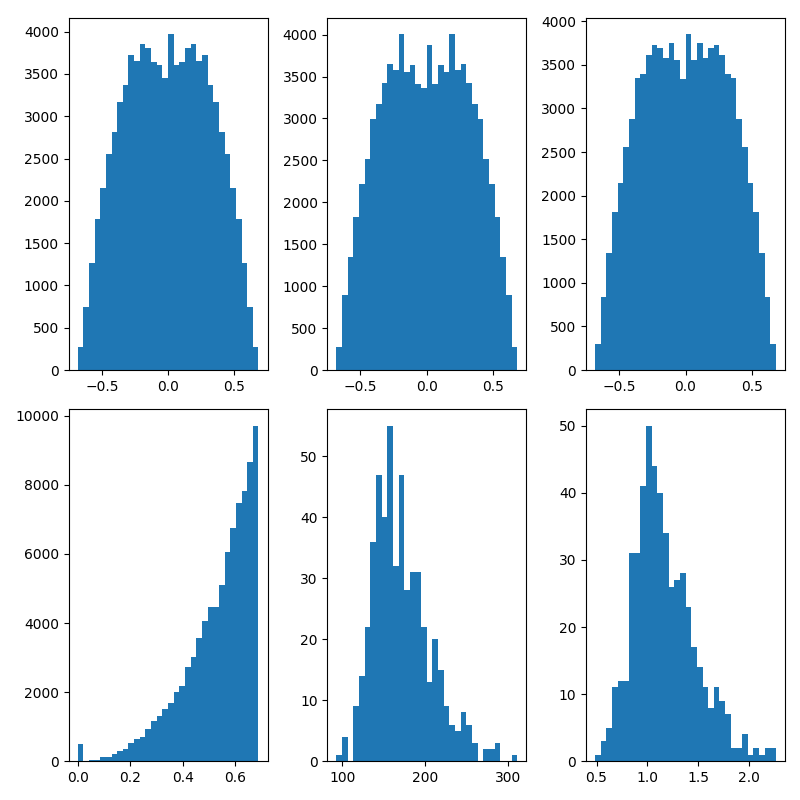

In [11]:
fig, axis = plt.subplots(2, 3, figsize=(8, 8), squeeze=False)

for d in range(dim):
    axis[0, d].hist(actualNeighbors[1].x_ij[:, d].cpu(), bins=32)

axis[1,0].hist(actualNeighbors[1].r_ij.cpu(), bins = 32)
axis[1,1].hist(particles.numNeighbors.cpu(), bins = 32)
axis[1,2].hist(particles.densities.cpu(), bins = 32)

fig.tight_layout()



In [12]:
from sphMath.operations import SPHOperation, Operation, scatter_sum

In [34]:

currentParticles = copy.deepcopy(particles)

positions = currentParticles.positions.clone().detach()
positions.requires_grad_()

# currentParticles.positions.requires_grad_()
currentParticles.positions = positions

# fluidPositions = currentParticles.positions[currentParticles.kinds == 0].clone().detach()
# boundaryPositions = currentParticles.positions[currentParticles.kinds == 1].clone().detach()
# ghostPositions = currentParticles.positions[currentParticles.kinds == 2].clone().detach()
# fluidPositions.requires_grad = True
# fluidPositions.grad = None

# currentParticles.positions = torch.cat([boundaryPositions, fluidPositions, ghostPositions], dim = 0)

# currentParticles.positions.requires_grad = True
# currentParticles.positions.grad = None
optimizer = torch.optim.Adam([positions], lr = 1e-3)
# optimizer = torch.optim.SGD([fluidPositions], lr = 1e-3)
neighborhood = None

rhos = []
colors = []
colorGrads = [] 
updates = []

rhoLosses = []
colorLosses = []
colorGradLosses = []
losses = []
regularizerTerms = []

for i in (t:= tqdm(range(2**12))):
    optimizer.zero_grad()
    # positions.grad = None
    currentParticles.positions = positions
    # currentParticles.positions.grad = None
    # currentParticles.densities.grad = None
    # print('densities:', currentParticles.densities)
    # print(currentParticles.positions)
    # currentParticles.densities = None
    # currentParticles.positions = torch.cat([boundaryPositions, fluidPositions, ghostPositions], dim = 0)


    neighborhood, neighbors = evaluateNeighborhood(currentParticles, domain, wrappedKernel, verletScale = 1.0, mode = SupportScheme.SuperSymmetric, priorNeighborhood=None, computeHessian=False, computeDkDh=False, only_j = False, useCheckpoint=False)

    # print(neighbors.get('noghost')[1])

    rho = SPHOperation(currentParticles, None, wrappedKernel, neighbors.get('noghost')[0],  neighbors.get('noghost')[1], operation = Operation.Density, supportScheme = SupportScheme.Gather)
    currentParticles.densities = rho
    rhoLoss = torch.mean((rho -1)**2)
    
    # print(rho)

    color = SPHOperation(currentParticles, torch.ones_like(rho), wrappedKernel, neighbors.get('noghost')[0],  neighbors.get('noghost')[1], operation = Operation.Interpolate, supportScheme = SupportScheme.Gather)
    colorGrad = SPHOperation(currentParticles, color, wrappedKernel, neighbors.get('noghost')[0],  neighbors.get('noghost')[1], operation = Operation.Gradient, supportScheme = SupportScheme.Gather, gradientMode=GradientMode.Difference)

    colorLoss = torch.mean((color - 1)**2)
    colorGradLoss = torch.mean(torch.linalg.norm(colorGrad, dim = -1) * currentParticles.supports)**2

    kernelValues = neighbors.get('noghost')[1]
    neighbors_ = neighbors.get('noghost')[0]
    regularizer = config['particle']['dx']*0.8 - kernelValues.r_ij[neighbors_.row != neighbors_.col]
    regularizerTerm = torch.mean(regularizer[regularizer > 0]**2) if regularizer[regularizer > 0].numel() > 0 else torch.tensor(0.0, device=device, dtype=dtype)

    # loss = rhoLoss +regularizerTerm#+ (colorGradLoss*particles.supports.max().item())**2
    # loss = colorGradLoss*particles.supports.max() + rhoLoss

    # loss =((rho - 1)**2).max()
    # loss = colorGradLoss + regularizerTerm #+ rhoLoss
    # loss = torch.sqrt(loss)
    if regularizerTerm > 1e-4:
        loss = colorGradLoss + regularizerTerm + rhoLoss
    else:
        loss = colorGradLoss + rhoLoss


    # i, j = neighbors.get('noghost')[0].row, neighbors.get('noghost')[0].col
    # loss = scatter_sum(particles.masses[j] * neighbors.get('noghost')[1].W_i, i, dim = 0, dim_size = currentParticles.positions.shape[0])
    # loss = torch.mean((loss - 1)**2)

    # print(rhoLoss)

    loss.backward()
    # currentParticles.positions.grad = currentParticles.positions.grad - currentParticles.positions.grad.mean(dim = 0, keepdim = True)

    maxGrad = torch.linalg.norm(currentParticles.positions.grad, dim = -1).max()
    t.set_description(f'rhoLoss: {rhoLoss.item():7.4e}, colorLoss: {colorLoss.item():7.4e}, colorGradLoss: {colorGradLoss.item():7.4e}, loss: {loss.item():7.4e}, maxGrad: {maxGrad.item():7.4e}, regularizer: {regularizerTerm.item():7.4e}')


    # fluidPositions.grad.clamp_(min = -0.1*dx, max = 0.1*dx)

    optimizer.step()

    rhos.append(rho.detach().cpu().numpy())
    colors.append(color.detach().cpu().numpy())
    colorGrads.append(colorGrad.detach().cpu().numpy())
    updates.append(currentParticles.positions.grad.detach().cpu().numpy())
    rhoLosses.append(rhoLoss.item())
    colorLosses.append(colorLoss.item())
    colorGradLosses.append(colorGradLoss.item())
    losses.append(loss.item())
    regularizerTerms.append(regularizerTerm.item())

    # break

  0%|          | 0/4096 [00:00<?, ?it/s]

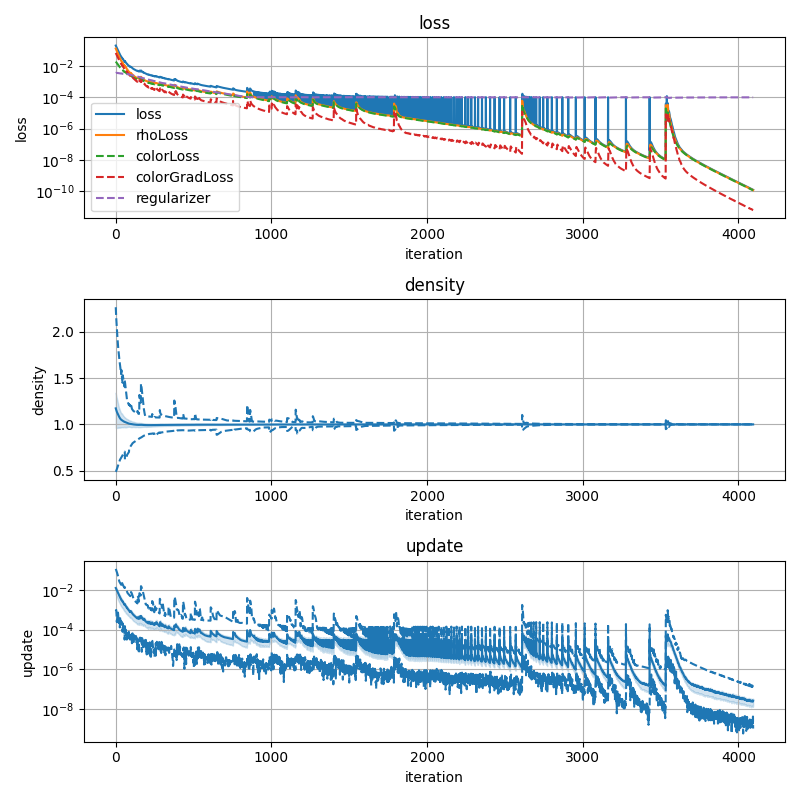

In [35]:
import numpy as np 
fig, axis = plt.subplots(3, 1, figsize=(8, 8), squeeze=False)

colorCycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
col0 = colorCycle[0]

axis[0,0].plot(losses, label = 'loss')
axis[0,0].plot(rhoLosses, label = 'rhoLoss')
axis[0,0].plot(colorLosses, linestyle = '--', label = 'colorLoss')
axis[0,0].plot(colorGradLosses, linestyle = '--', label = 'colorGradLoss')
axis[0,0].plot(regularizerTerms, linestyle = '--', label = 'regularizer')

axis[0,0].set_title('loss')
axis[0,0].set_xlabel('iteration')
axis[0,0].set_ylabel('loss')
axis[0,0].set_yscale('log')
axis[0,0].grid()
axis[0,0].legend()

axis[1,0].plot([np.mean(rho) for rho in rhos], color = col0)
axis[1,0].plot([np.min(rho) for rho in rhos], color = col0, linestyle = '--')
axis[1,0].plot([np.max(rho) for rho in rhos], color = col0, linestyle = '--')
quartiles = [np.percentile(rho, [25, 50, 75]) for rho in rhos]
axis[1,0].fill_between(range(len(rhos)), [q[0] for q in quartiles], [q[2] for q in quartiles], color = col0, alpha = 0.2)


axis[1,0].set_title('density')
axis[1,0].set_xlabel('iteration')
axis[1,0].set_ylabel('density')
axis[1,0].grid()

axis[2,0].plot([np.linalg.norm(update, axis = -1).mean() for update in updates], color = col0)
axis[2,0].plot([np.linalg.norm(update, axis = -1).min() for update in updates], linestyle = '--', color = col0)
axis[2,0].plot([np.linalg.norm(update, axis = -1).max() for update in updates], linestyle = '--', color = col0)
quartiles = [np.percentile(np.linalg.norm(update, axis = -1), [25, 50, 75]) for update in updates]
axis[2,0].fill_between(range(len(updates)), [q[0] for q in quartiles], [q[2] for q in quartiles], color = col0, alpha = 0.2)
axis[2,0].set_title('update')
axis[2,0].set_xlabel('iteration')
axis[2,0].set_ylabel('update')
axis[2,0].grid()
axis[2,0].set_yscale('log')
fig.tight_layout()

# display(fig)

In [36]:
currentParticles.densities = None
currentParticles.positions = positions
neighborhood, neighbors = evaluateNeighborhood(currentParticles, domain, wrappedKernel, verletScale = config['verletScale'], mode = SupportScheme.SuperSymmetric, priorNeighborhood=neighborhood)



rho = SPHOperation(currentParticles, None, wrappedKernel, neighbors.get('noghost')[0],  neighbors.get('noghost')[1], operation = Operation.Density, supportScheme = SupportScheme.Gather)
currentParticles.densities = rho

In [37]:
((1-rho)**2).mean()

tensor(1.1944e-10, device='cuda:0', grad_fn=<MeanBackward0>)

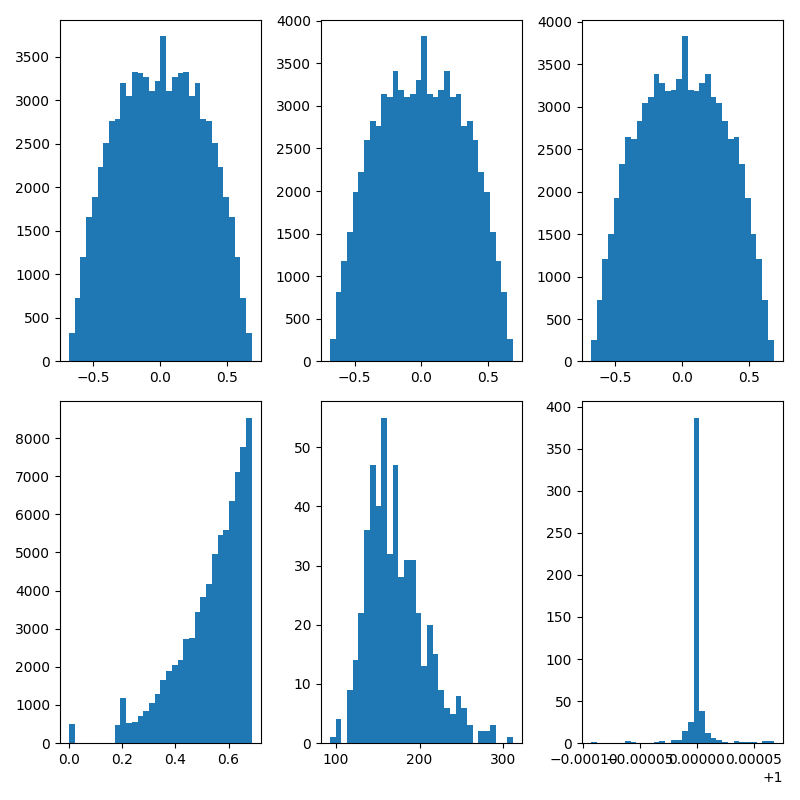

In [43]:
fig, axis = plt.subplots(2, 3, figsize=(8, 8), squeeze=False)

actualNeighbors = neighbors.get('noghost')

for d in range(dim):
    axis[0, d].hist(actualNeighbors[1].x_ij[:, d].detach().cpu(), bins=32)

axis[1,0].hist(actualNeighbors[1].r_ij.detach().cpu(), bins = 32)
axis[1,1].hist(currentParticles.numNeighbors.detach().cpu(), bins = 32)
axis[1,2].hist(currentParticles.densities.detach().cpu(), bins = 32)

fig.tight_layout()



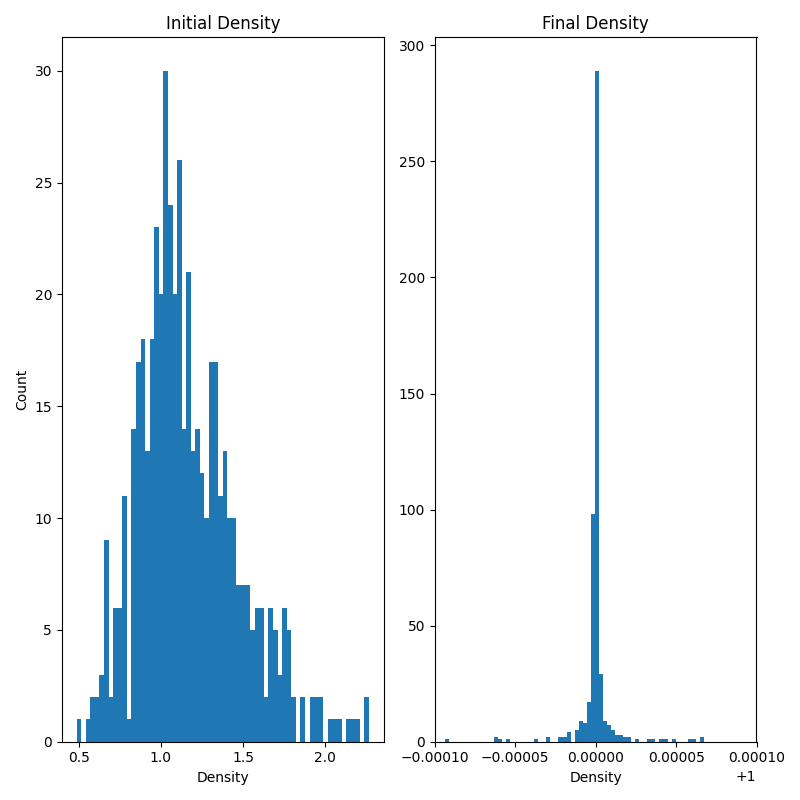

In [52]:
fig, axis = plt.subplots(1, 2, figsize=(8, 8), squeeze=False)

axis[0,0].hist(particles.densities.detach().cpu(), bins = 64)
axis[0,1].hist(currentParticles.densities.detach().cpu(), bins = 64)
axis[0,1].set_xlim(0.9999, 1.0001)

axis[0,0].set_title('Initial Density')
axis[0,1].set_title('Final Density')
axis[0,0].set_xlabel('Density')
axis[0,1].set_xlabel('Density')
axis[0,0].set_ylabel('Count')

fig.tight_layout()



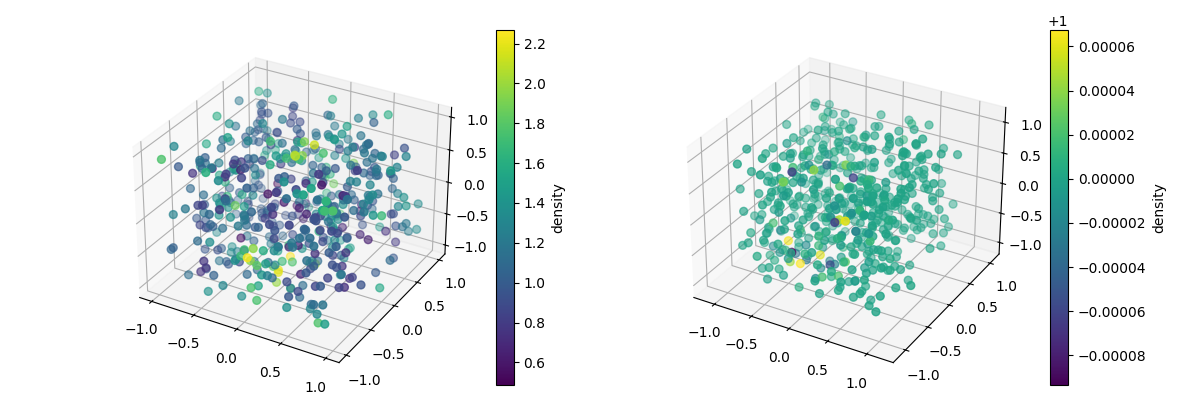

In [42]:
fig, axis = plt.subplots(1, 2, figsize=(12, 4), squeeze=False, subplot_kw = {'projection': '3d'})

sc = axis[0,0].scatter(particles.positions[:, 0].detach().cpu(), particles.positions[:, 1].detach().cpu(), particles.positions[:, 2].detach().cpu(), c = particles.densities.detach().cpu(), s = 32)
fig.colorbar(sc, ax = axis[0,0], label = 'density')

sc = axis[0,1].scatter(currentParticles.positions[:, 0].detach().cpu(), currentParticles.positions[:, 1].detach().cpu(), currentParticles.positions[:, 2].detach().cpu(), c = currentParticles.densities.detach().cpu(), s = 32)
fig.colorbar(sc, ax = axis[0,1], label = 'density')

fig.tight_layout()


TypeError: 'NoneType' object is not subscriptable

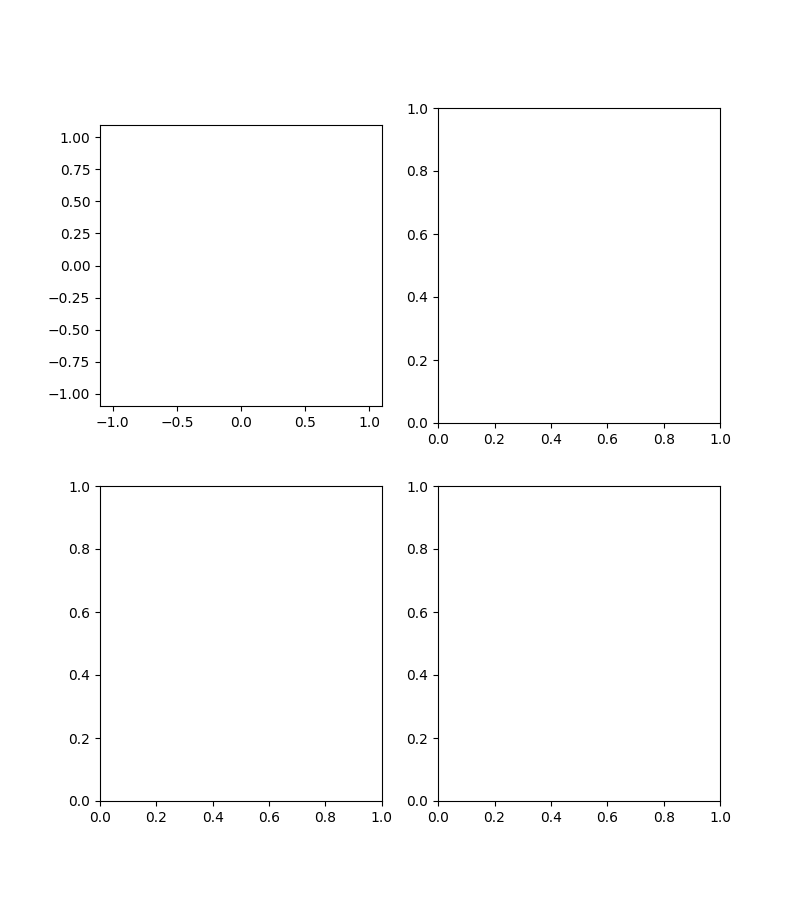

In [19]:
fig, axis = plt.subplots(2, 2, figsize=(8, 9), squeeze=False)

markerSize = 5

rhoPlot = visualizeParticles(fig, axis[0,0], 
            particles = currentParticles, 
            domain = domain, 
            quantity = rho, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'viridis',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
colorPlot = visualizeParticles(fig, axis[0,1],
            particles = currentParticles, 
            domain = domain, 
            quantity = color, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'magma',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
colorGradXPlot = visualizeParticles(fig, axis[1,0],
            particles = currentParticles, 
            domain = domain, 
            quantity = colorGrad, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'berlin',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
colorGradYPlot = visualizeParticles(fig, axis[1,1],
            particles = currentParticles, 
            domain = domain, 
            quantity = colorGrad, 
            which = 'fluid',
            mapping = '.y',
            cmap = 'berlin',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)

axis[0,0].set_title(r'$\rho$')
axis[0,1].set_title(r'c')
axis[1,0].set_title(r'$\nabla c_x$')
axis[1,1].set_title(r'$\nabla c_y$')

fig.tight_layout()

display(fig)

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(8, 9), squeeze=False)

markerSize = 2

rhoPlot = visualizeParticles(fig, axis[0,0], 
            particles = currentParticles, 
            domain = domain, 
            quantity = rho, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'viridis',
            visualizeBoth=False,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
colorPlot = visualizeParticles(fig, axis[0,1],
            particles = currentParticles, 
            domain = domain, 
            quantity = (rho - 1)**2, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'RdBu_r',
            visualizeBoth=False,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
colorGradXPlot = visualizeParticles(fig, axis[1,0],
            particles = currentParticles, 
            domain = domain, 
            quantity = currentParticles.positions.grad[:,0], 
            which = 'fluid',
            mapping = '.x',
            cmap = 'berlin',
            visualizeBoth=False,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
colorGradYPlot = visualizeParticles(fig, axis[1,1],
            particles = currentParticles, 
            domain = domain, 
            quantity = currentParticles.positions.grad[:,1], 
            which = 'fluid',
            mapping = '.y',
            cmap = 'berlin',
            visualizeBoth=False,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)

fig.tight_layout()

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
dtype = torch.float32

nx = 64
L = 2
dim = 2
kernel = 'Wendland4'
targetNeighbors = n_h_to_nH(4,dim)
CFL = 0.3

integrationScheme = 'symplecticEuler'
dx = L / nx
band = 5

domain = buildDomainDescription(l = 2, dim = dim, periodic = True, device = device, dtype = dtype)
# domain.min = torch.tensor([-L/2, -2*L], device = device, dtype = dtype)
# domain.max = torch.tensor([L/2, 2*L], device = device, dtype = dtype)
# print(domain.min)
# domain.min = torch.tensor([-2*L/2,-L/2], device = device, dtype = dtype)
# domain.max = torch.tensor([5*L/2,L/2], device = device, dtype = dtype)
# interiorDomain = buildDomainDescription(l = L, dim = dim, periodic = False, device = device, dtype = dtype)
wrappedKernel = kernel
integrationScheme = getIntegrator(integrationScheme)

config = {
    'domain': domain,
    'kernel': wrappedKernel,
    'verletScale': 1.4,
    'shifting': {'scheme': 'delta', 'freeSurface': False},
    'surfaceDetection': {'active': False},
    'pressure':{'term': 'Antuono'},
    'fluid': {'rho0': 1, 'c_s': 20},    
    'gravity': {'active': False, 'magnitude': 9.81, 'mode': 'directional', 'direction': torch.tensor([0, -1], device = device, dtype = dtype)},
    'particle': {'nx': nx, 'dx': dx, 'targetNeighbors': targetNeighbors, 'band': band, 'support': volumeToSupport((L/nx)**dim, targetNeighbors, dim)},
}

In [ ]:
fluid_sdf = lambda x: sampleDomainSDF(x, domain, invert = True)
# domain_sdf = lambda x: sampleDomainSDF(x, interiorDomain, invert = False)
obstacle_sdf = lambda points: sampleSDF(points, lambda x: getSDF('horseshoe')['function'](x, torch.tensor([0., 1.]).to(points.device),0.5,0.1), invert = False)

obstacle_sdf2 = lambda x: getSDF('horseshoe')['function'](x, torch.tensor([0., 1.]).to(x.device),0.5,0.1)

# box_sdf = lambda points: sampleSDF(points, lambda x: getSDF('box')['function'](x, torch.tensor([0.5,0.5]).to(points.device)))

# inlet_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([L/16,L/2]).to(points.device)), torch.tensor([domain.min[0]+L/16,0]).to(points.device)), invert = False)
# outlet_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([L/12,L]).to(points.device)), torch.tensor([domain.max[0]-L/12,0]).to(points.device)), invert = False)
# outletBuffer_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([L/8,L]).to(points.device)), torch.tensor([domain.max[0]-L/8,0]).to(points.device)), invert = False)


regions = []

# regions.append(buildRegion(sdf = domain_sdf, config = config, type = 'boundary', kind = 'constant'))
# regions.append(buildRegion(sdf = obstacle_sdf, config = config, type = 'boundary', kind = 'constant'))
regions.append(buildRegion(sdf = obstacle_sdf, config = config, type = 'fluid'))
# regions.append(buildRegion(sdf = fluid_sdf, config = config, type = 'forcing', dirichletValues={'velocities': forcing}))

# regions.append(buildRegion(sdf = inlet_sdf, config = config, type = 'inlet', dirichletValues={'densities': config['fluid']['rho0'], 'velocities': torch.tensor([1,0], device = device, dtype = dtype)}, updateValues = {'densities': 0, 'velocities': torch.tensor([0,0], device = device, dtype = dtype)}))

# regions.append(buildRegion(sdf = outlet_sdf, config = config, type = 'outlet'))
# regions.append(buildRegion(sdf = outletBuffer_sdf, config = config, type = 'buffer', bufferValues = ['densities', 'velocities', 'pressures']))

# regions.append(buildRegion(sdf = box_sdf, config = config, type = 'dirichlet', dirichletValues={'densities': 2.0, 'velocities': torch.tensor([1,2], device = device, dtype = dtype), 'pressures': lambda x: torch.where(x[:,0] > 0, 0.0, 1.0)}, updateValues = {'densities': 2.0}))


for region in regions:
    region = filterRegion(region, regions)


fig, axis = plt.subplots(1, 1, figsize=(8, 5), squeeze=False)
    
plotRegions(regions, axis[0,0], plotFluid = True, plotParticles = False)
axis[0,0].set_aspect('equal')




In [ ]:

from sphMath.modules.particleShifting import computeShifting, solveShifting
particleState, config, rigidBodies = initializeSimulation(scheme, config, regions)

particles = copy.deepcopy(particleState)
particleSystem = DeltaPlusSPHSystem(domain, None, 0., copy.deepcopy(particleState), 'momentum', None, rigidBodies = rigidBodies, regions = config['regions'], config = config)

for rigidBody in rigidBodies:
    particleState = updateBodyParticles(scheme, particleState, rigidBody)

kindMask = particleSystem.systemState.kinds == 0
jitter = torch.randn_like(particleSystem.systemState.positions) * particleSystem.systemState.supports.view(-1,1) * 0.05
jitter[~kindMask,:] = 0

particleSystem.systemState.positions += jitter

particleSystem.systemState.positions[kindMask] = torch.rand_like(particleSystem.systemState.positions[kindMask]) * (domain.max - domain.min) + domain.min

configS = {
    'domain': domain,
    'kernel': config['kernel'],
    'verletScale': 1.4,
    'particle': {'dx': config['particle']['dx'], 'support': particles.supports.max().item()},
    'shifting': {'scheme': 'delta',
                'threshold': 5,
                'computeMach': False,
                'summationDensity': True
                }
}

for i in tqdm(range(32)):
    dx, *_ = solveShifting(particleSystem, 0.1, configS)
    particleSystem.systemState.positions[kindMask,:] += dx[kindMask,:]
    # print(torch.linalg.norm(dx, dim = -1).max().item())
    
config['timestep'] = {'CFL': CFL, 'dt': 1e-3, 'maxDt': 1e-2, 'minDt': 1e-6}
dt = computeTimestep(scheme, 1e-2, particleSystem.systemState, config, None)
print(dt)
config['timestep']['dt'] = dt

kineticEnergy = 0.5 * particleState.densities * (particleState.velocities ** 2).sum(1)

t = 0
E_k0 = 0.5 * particleState.masses * torch.linalg.norm(particleState.velocities, dim = -1)**2
E_k = 0.5 * particleState.masses * torch.linalg.norm(particleState.velocities, dim = -1)**2

rhoMin = particleState.densities.min().detach().cpu().item() / config['fluid']['rho0']
rhoMean = particleState.densities.mean().detach().cpu().item() / config['fluid']['rho0']
rhoMax = particleState.densities.max().detach().cpu().item() / config['fluid']['rho0']


initialVelocity = particleState.velocities.clone()
initialDensities = particleState.densities.clone()

initialKineticEnergy = 0.5 * particleState.masses / config['fluid']['rho0'] * particleState.densities * torch.linalg.norm(initialVelocity, dim = -1)**2

particleState = particleSystem.systemState

In [ ]:
from sphMath.neighborhood import evaluateNeighborhood, SupportScheme
from sphMath.operations import SPHOperation, Operation, GradientMode


fig, axis = plt.subplots(2, 2, figsize=(8, 9), squeeze=False)

markerSize = 0.25
currentParticles = copy.deepcopy(particleSystem.systemState)

neighborhood, neighbors = evaluateNeighborhood(currentParticles, domain, wrappedKernel, verletScale = config['verletScale'], mode = SupportScheme.SuperSymmetric, priorNeighborhood=None)
rho = SPHOperation(currentParticles, None, kernel, neighbors.get('noghost')[0], neighbors.get('noghost')[1], operation = Operation.Density, supportScheme = SupportScheme.Gather)

color = SPHOperation(currentParticles, torch.ones_like(rho), kernel, neighbors.get('noghost')[0], neighbors.get('noghost')[1], operation = Operation.Interpolate, supportScheme = SupportScheme.Gather)
colorGrad = SPHOperation(currentParticles, color, kernel, neighbors.get('noghost')[0], neighbors.get('noghost')[1], operation = Operation.Gradient, supportScheme = SupportScheme.Gather, gradientMode=GradientMode.Difference)

rhoPlot = visualizeParticles(fig, axis[0,0], 
            particles = currentParticles, 
            domain = domain, 
            quantity = rho, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'viridis',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
colorPlot = visualizeParticles(fig, axis[0,1],
            particles = currentParticles, 
            domain = domain, 
            quantity = color, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'magma',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
colorGradXPlot = visualizeParticles(fig, axis[1,0],
            particles = currentParticles, 
            domain = domain, 
            quantity = colorGrad, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'berlin',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
colorGradYPlot = visualizeParticles(fig, axis[1,1],
            particles = currentParticles, 
            domain = domain, 
            quantity = colorGrad, 
            which = 'fluid',
            mapping = '.y',
            cmap = 'berlin',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)

fig.tight_layout()

In [ ]:

t = 0
currentParticles = copy.deepcopy(particleSystem.systemState)

fluidPositions = currentParticles.positions[currentParticles.kinds == 0].clone().detach()
boundaryPositions = currentParticles.positions[currentParticles.kinds == 1].clone().detach()
ghostPositions = currentParticles.positions[currentParticles.kinds == 2].clone().detach()
fluidPositions.requires_grad = True

currentParticles.positions = torch.cat([boundaryPositions, fluidPositions, ghostPositions], dim = 0)

# currentParticles.positions.requires_grad = True
# currentParticles.positions.grad = None
optimizer = torch.optim.Adam([fluidPositions], lr = 5e-4)
neighborhood = None

rhos = []
colors = []
colorGrads = [] 
updates = []

rhoLosses = []
colorLosses = []
colorGradLosses = []
losses = []

for i in (t:= tqdm(range(2**16))):
    optimizer.zero_grad()
    currentParticles.positions = torch.cat([boundaryPositions, fluidPositions, ghostPositions], dim = 0)
    neighborhood, neighbors = evaluateNeighborhood(currentParticles, domain, wrappedKernel, verletScale = config['verletScale'], mode = SupportScheme.SuperSymmetric, priorNeighborhood=neighborhood)
    rho = SPHOperation(currentParticles, None, wrappedKernel, neighbors.get('noghost')[0],  neighbors.get('noghost')[1], operation = Operation.Density, supportScheme = SupportScheme.Gather)
    currentParticles.densities = rho

    color = SPHOperation(currentParticles, torch.ones_like(rho), wrappedKernel, neighbors.get('noghost')[0],  neighbors.get('noghost')[1], operation = Operation.Interpolate, supportScheme = SupportScheme.Gather)
    colorGrad = SPHOperation(currentParticles, torch.ones_like(rho), wrappedKernel, neighbors.get('noghost')[0],  neighbors.get('noghost')[1], operation = Operation.Gradient, supportScheme = SupportScheme.Gather, gradientMode=GradientMode.Naive)

    rhoLoss = torch.mean((rho -1)**2)
    colorLoss = torch.mean((color - 1)**2)
    colorGradLoss = torch.mean(torch.linalg.norm(colorGrad, dim = -1))**2

    kernelValues = neighbors.get('noghost')[1]
    neighbors_ = neighbors.get('noghost')[0]
    regularizer = config['particle']['dx'] - kernelValues.r_ij[neighbors_.row != neighbors_.col]
    regularizerTerm = torch.sum(regularizer[regularizer > 0])

    loss = rhoLoss + colorLoss #+ (colorGradLoss*particles.supports.max().item())**2
    # loss = colorGradLoss*particles.supports.max() + rhoLoss

    # loss =((rho - 1)**2).max()
    loss = torch.sqrt(loss)
    loss = colorGradLoss + regularizerTerm
    sdfDistance = obstacle_sdf2(fluidPositions).clamp(min = 0).sum()
    
    loss = sdfDistance + regularizerTerm + ((rho-1).clamp(min=0)**2).sum()

    # print(rhoLoss)

    t.set_description(f'rhoLoss: {rhoLoss.item():7.4e}, colorLoss: {colorLoss.item():7.4e}, colorGradLoss: {colorGradLoss.item():7.4e}, loss: {loss.item():7.4e}, sdfDistance: {sdfDistance.mean().item():7.4e}')

    loss.backward()
    optimizer.step()

    rhos.append(rho.detach().cpu().numpy())
    colors.append(color.detach().cpu().numpy())
    colorGrads.append(colorGrad.detach().cpu().numpy())
    updates.append(fluidPositions.grad.detach().cpu().numpy())
    rhoLosses.append(rhoLoss.item())
    colorLosses.append(colorLoss.item())
    colorGradLosses.append(colorGradLoss.item())
    losses.append(loss.item())

    # break

In [ ]:
from sphMath.neighborhood import evaluateNeighborhood, SupportScheme
from sphMath.operations import SPHOperation, Operation, GradientMode


fig, axis = plt.subplots(2, 2, figsize=(8, 9), squeeze=False)

markerSize = 8

neighborhood, neighbors = evaluateNeighborhood(currentParticles, domain, wrappedKernel, verletScale = config['verletScale'], mode = SupportScheme.SuperSymmetric, priorNeighborhood=None)
rho = SPHOperation(currentParticles, None, kernel, neighbors.get('noghost')[0], neighbors.get('noghost')[1], operation = Operation.Density, supportScheme = SupportScheme.Gather)

color = SPHOperation(currentParticles, torch.ones_like(rho), kernel, neighbors.get('noghost')[0], neighbors.get('noghost')[1], operation = Operation.Interpolate, supportScheme = SupportScheme.Gather)
colorGrad = SPHOperation(currentParticles, color, kernel, neighbors.get('noghost')[0], neighbors.get('noghost')[1], operation = Operation.Gradient, supportScheme = SupportScheme.Gather, gradientMode=GradientMode.Difference)

rhoPlot = visualizeParticles(fig, axis[0,0], 
            particles = currentParticles, 
            domain = domain, 
            quantity = rho, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'viridis',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
colorPlot = visualizeParticles(fig, axis[0,1],
            particles = currentParticles, 
            domain = domain, 
            quantity = obstacle_sdf2(fluidPositions).detach().clamp(min = 0), 
            which = 'fluid',
            mapping = '.x',
            cmap = 'magma',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
colorGradXPlot = visualizeParticles(fig, axis[1,0],
            particles = currentParticles, 
            domain = domain, 
            quantity = colorGrad, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'berlin',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
colorGradYPlot = visualizeParticles(fig, axis[1,1],
            particles = currentParticles, 
            domain = domain, 
            quantity = colorGrad, 
            which = 'fluid',
            mapping = '.y',
            cmap = 'berlin',
            visualizeBoth=True,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)

for ax in axis.flatten():
    plotRegions(regions, ax, plotFluid = True, plotParticles = False)
    
fig.tight_layout()